# The moments of the distribution for mRNA in a two- and three-state promoter.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

In [33]:
import glob
import pickle
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
# To compute symbolic expressions
import sympy
# sympy.init_printing(use_unicode=True) # print outputs in LaTeX
sympy.init_printing(use_latex=True) # print outputs in LaTeX

import pandas as pd
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# figdir = '../../fig/chemical_master_analytic_mRNA/'
tmpdir = '../../tmp/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$

# Two-state promoter (mRNA)

In this section we will perform the linear algebra to solve for the steady-state moments of the mRNA distribution.

Up to this stage we wrote the chemical master equation in matrix notation and did some tricks when it came to compute the $n^{\text{th}}$ moment. Now we will use the equations we obtained for the time derivative of the mRNA distribution moments and set that to steady-state to solve for the moments themselves.

Let's first define the `sympy` variables that we will need for the two- and three-state promoter.

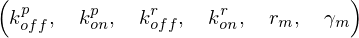

In [2]:
# Define rate constant variables
kp_off, kp_on = sympy.symbols('{k_{off}^p} {k_{on}^p}')
kr_off, kr_on = sympy.symbols('{k_{off}^r} {k_{on}^r}')

# Define degradation rate and production rate
rm, gm = sympy.symbols('r_m gamma_m')

kp_off, kp_on, kr_off, kr_on, rm, gm

Let's now define a function that generates a `sympy` variable of the form $\left\langle x^n \right\rangle$ to easily define the variables to save the moments.

In [3]:
def moment_sympy(var, moment):
    '''
    Shortcut to generate variables of the form <var**n> in sympy to facilitate the
    definition of the moment variables
    Parameters
    ----------
    var : string.
        variable name string that should be put inside the <> parenthesis.
    moment : int.
        exponent of the moment to be defined.
    '''
    return sympy.Symbol('{\\langle ' + var + '^{:d}'.format(moment) + '\\rangle}')

Now let's define the moment variables for the unregulated promoter.

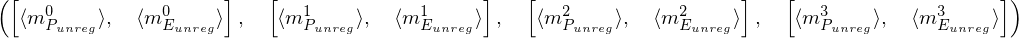

In [4]:
# Define the string for the states
m_unreg = ['m_{P_{unreg}}', 'm_{E_{unreg}}']

# Define the zeroth moments
m0_unreg = [moment_sympy(x, 0) for x in m_unreg]
# Define the first moments
m1_unreg = [moment_sympy(x, 1) for x in m_unreg]
# Define the second moments
m2_unreg = [moment_sympy(x, 2) for x in m_unreg]
# Define the second moments
m3_unreg = [moment_sympy(x, 3) for x in m_unreg]

m0_unreg, m1_unreg, m2_unreg, m3_unreg

Now we will define the state transition matrix $\mathbf{K}^u$, the mRNA production matrix $\mathbf{R}^u_m$ and the mRNA degradation matrix $\mathbf{\Gamma}^u_m$.

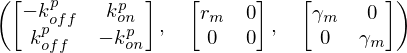

In [5]:
# Define the rate constant matrix
Kmat_unreg = sympy.Matrix([[-kp_off, kp_on], 
                           [kp_off, -kp_on]])
# Define the production matrix
Rmat_unreg = sympy.Matrix([[rm, 0], 
                           [0, 0]])
# Define the degradation matrix
Gmat_unreg = sympy.Matrix([[gm, 0],
                           [0, gm]])

Kmat_unreg, Rmat_unreg, Gmat_unreg

### Zeroth moment two-state promoter
In order to solve for the two-state promoter we have two equations to use
$$
1 = \mathbf{u} \cdot \left\langle \mathbf{m}^0 \right\rangle,
$$
where $u = (1, 1)$ and $\left\langle \mathbf{m}^0 \right\rangle$ is the vector containing all the states, and
$$
\mathbf{0} = \mathbf{K}^u_m \left\langle \mathbf{m}^0 \right\rangle.
$$

We will use the linear algebra solver where we write an extended matrix with the last column being the right hand side of these equations.

Let's now define this extended matrix.

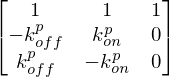

In [6]:
# Add the extra row for the normalization constraint
K_sys_unreg = Kmat_unreg.row_insert(0, sympy.Matrix([1, 1]).transpose())

# Define right-side array
b = sympy.Matrix([1, 0, 0])

# Define augmented matrix
zero_aug_unreg = K_sys_unreg.col_insert(2, b)
zero_aug_unreg

Now we solve the equation for the two state moments.

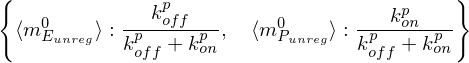

In [7]:
# Solve linear system for the three zeroth moments
zero_sol_unreg = sympy.solve_linear_system(zero_aug_unreg, *m0_unreg)
zero_sol_unreg

### First moment two-state promoter

Now that we have the zeroth moment that indicates the probability of being on either state let's now compute the first moment. For this we have the matrix equation
$$
\mathbf{0} = \left( \mathbf{K}^u_m - \mathbf{\Gamma}^u_m  \right)
             + \mathbf{R}^u_m \left\langle \mathbf{m}^0 \right\rangle.
$$

Let's write this system in the form of the augmented matrix.

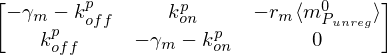

In [8]:
# Define augmented matrix for first moment
first_aug_unreg = (Kmat_unreg - Gmat_unreg).col_insert(2, 
                                            -Rmat_unreg * sympy.Matrix(m0_unreg))
first_aug_unreg

And again we use the `sympy` solver to solve for the first moments

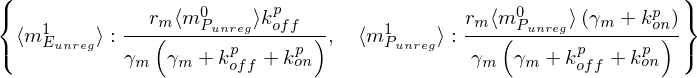

In [9]:
# Solve linear system for the three moments
first_sol_unreg = sympy.solve_linear_system(first_aug_unreg, *m1_unreg)
first_sol_unreg

We now sum both elements and substitute the solution for the zeroth moments

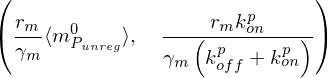

In [10]:
first_unreg = sum(first_sol_unreg.values()).simplify()
first_unreg_s = first_unreg.subs(zero_sol_unreg)
first_unreg, first_unreg_s

### Second moment two-state promoter

Finally for the second moment we have an equation of the form
$$
\mathbf{0} = \left( \mathbf{K}^u_m - 2 \mathbf{\Gamma}^u_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 2 \mathbf{R}^u_m + \mathbf{\Gamma}^u_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^u_m
             \left\langle \mathbf{m}^0 \right\rangle
$$

Let's again define this augmented matrix.

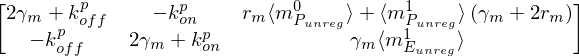

In [11]:
# Define augmented matrix for second moment
second_aug_unreg = (2 * Gmat_unreg - Kmat_unreg).col_insert(2, 
                   (2 * Rmat_unreg + Gmat_unreg) * sympy.Matrix(m1_unreg)\
                   + Rmat_unreg * sympy.Matrix(m0_unreg))
second_aug_unreg

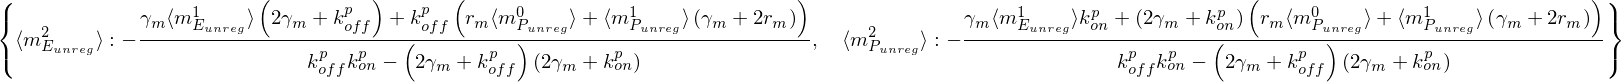

In [12]:
# Solve linear system for the three moments
second_sol_unreg = sympy.solve_linear_system(second_aug_unreg, *m2_unreg)
second_sol_unreg

Again let's add both of these moments to obtain the global second moment.

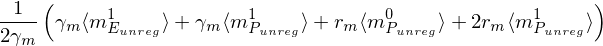

In [13]:
second_unreg = sum(second_sol_unreg.values()).simplify()
second_unreg

Let's now substitute the solution for the sum of the first moments.

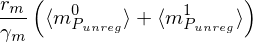

In [14]:
second_unreg_s = second_unreg.subs(gm * m1_unreg[0] + gm * m1_unreg[1], 
                  gm * sympy.simplify(sum(first_sol_unreg.values())))
second_unreg_s.simplify()

This is the answer shown in PBoC. Now is a matter of substituting the other solutions to obtain the second moment.

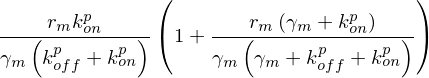

In [15]:
second_unreg_ss = sympy.simplify(second_unreg_s).\
                  subs(first_sol_unreg).subs(zero_sol_unreg).\
                  collect(kp_on / (kp_on + kp_off))
second_unreg_ss

Let's now compute the variance and the fano-factor to confirm that we obtain the exact same results as derived in PBoC.

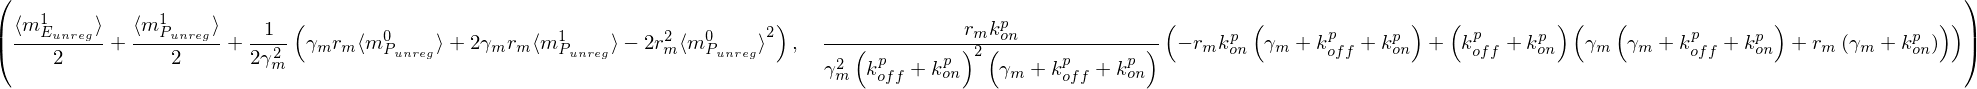

In [16]:
# Compute the variance of the unregulated promoter
var_unreg = second_unreg - first_unreg**2
var_unreg_s = var_unreg.subs(first_sol_unreg).subs(zero_sol_unreg)
var_unreg.ratsimp(), var_unreg_s.simplify()

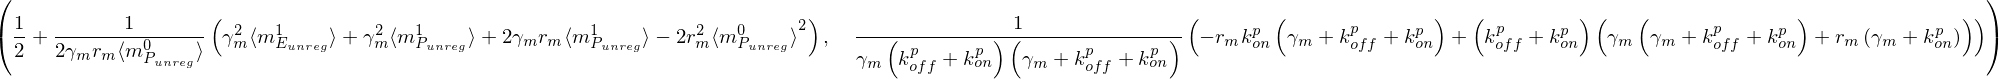

In [17]:
# Compute the fano factor of the unregulated promoter
fano_unreg = var_unreg / first_unreg
fano_unreg_s = fano_unreg.subs(first_sol_unreg).subs(zero_sol_unreg)
fano_unreg.ratsimp(), fano_unreg_s.simplify()

Let's manually define the fano-factor as reported in PBoC and compare both expressions.

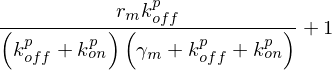

In [18]:
fano_pboc = 1 + kp_off / (kp_off + kp_on) * rm / (kp_off + kp_on + gm)
fano_pboc

In [19]:
fano_pboc.ratsimp() == fano_unreg_s.ratsimp()

True

### Third moment two-state promoter

As an extra derivation we will include the 3rd moment in our calculation. This will be useful to define the equations to compute the parameters. The matrix equation for the 3rd moment is given by
$$
\mathbf{0} = \left( \mathbf{K}^u_m - 3 \mathbf{\Gamma}^u_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \mathbf{R}^u_m + 3 \mathbf{\Gamma}^u_m \right)
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \mathbf{R}^u_m - \mathbf{\Gamma}^u_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^u_m
             \left\langle \mathbf{m}^0 \right\rangle
$$

Let's again define this augmented matrix.

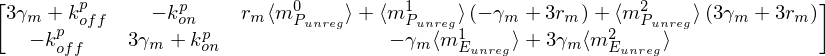

In [20]:
# Define augmented matrix for third moment
third_aug_unreg = (3 * Gmat_unreg - Kmat_unreg).col_insert(2, 
                  (3 * Rmat_unreg + 3 * Gmat_unreg) * sympy.Matrix(m2_unreg)\
                  + (3 * Rmat_unreg - Gmat_unreg) * sympy.Matrix(m1_unreg)
                  + Rmat_unreg * sympy.Matrix(m0_unreg))
third_aug_unreg

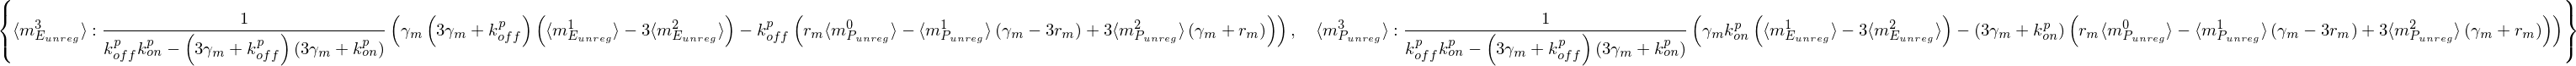

In [21]:
# Solve linear system for the three moments
third_sol_unreg = sympy.solve_linear_system(third_aug_unreg, *m3_unreg)
third_sol_unreg

As usual let's add these moments

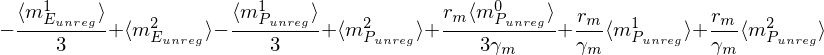

In [22]:
third_unreg = sum(third_sol_unreg.values()).simplify()
third_unreg

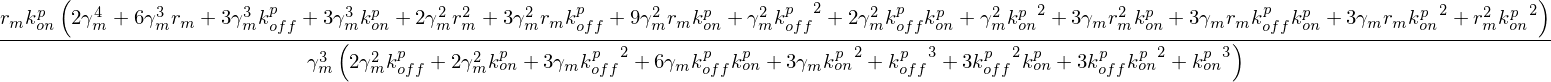

In [28]:
third_unreg_ss = third_unreg.subs(second_sol_unreg).\
                 subs(first_sol_unreg).subs(zero_sol_unreg)
third_unreg_ss.simplify()

## Deriving expressions for the parameters.

Just as Peccoud & Ycart did we will find equations that solve for the parameters in the equation.

In their paper Peccoud & Ycart note that by computing the exponential moments they can generate a system of equations simple enough to solve for almost all parameters in the equation. Not all four parameters can be uniquely determined since the model is homogeneous in time. What that implies is that multiplying the time scale by a constant is equivalent to dividing all parameters by the same constant and this does not affect the steady-state distribution. But if we define the parameters in units of $\gm$ we can find equations for the other three parameters.

The so-called exponential moments are defined as
$$
e_n \equiv \left\langle m (m - 1) \cdots (m - n + 1) \right\rangle.
$$
Given the linearity property of expected values these moments can be computed from knowing up to the highest regular moment. The first three exponential moments are given by
$$
e_1 = \mm,\\
e_2 = \left\langle m (m - 1) \right\rangle = \left\langle m^2 \right\rangle - \mm,\\
e_3 = \left\langle m (m - 1) (m - 2) \right\rangle =
\left\langle m^3 \right\rangle - 3\left\langle m^2 \right\rangle + 2\mm
$$

Peccoud and Ycart cleverly realize that by defining the successive ratios of these first three exponential moments one can get a system of three equations from which to extract the parameters. The consecutive ratios are simply given by
$$
r_1 \equiv e_1,\\
r_2 \equiv e_2 / e_1,
$$
and
$$
r_3 \equiv e_3 / e_2.
$$

Let's now define these three equations.

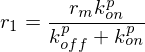

In [29]:
r1, r2, r3 = sympy.symbols('r_1 r_2 r_3')
r1_unreg = first_unreg_s.subs(gm, 1)
sympy.Eq(r1, r1_unreg)

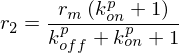

In [30]:
r2_unreg = ((second_unreg_ss - first_unreg_s) /\
            first_unreg_s).subs(gm, 1).simplify()
sympy.Eq(r2, r2_unreg)

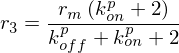

In [31]:
r3_unreg = ((third_unreg_ss - 3 * second_unreg_ss + 2 * first_unreg_s) / \
     (second_unreg_ss - first_unreg_s)).subs(gm, 1).simplify()
sympy.Eq(r3, r3_unreg)

Now let's use these three equations to solve for the parameters.

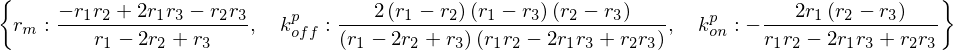

In [32]:
infer_param = [kp_on, kp_off, rm]
param_moments = sympy.solve([r1_unreg - r1,
                             r2_unreg - r2,
                             r3_unreg - r3], *infer_param)[0]
param_moments = dict(zip(infer_param, param_moments))
param_moments

So by simply computing this experimentally accessible quantities we can obtain estimates for the values of these kinetic parameters.

### Export solutions to `pickle` object

In order to import these results in another notebook we will save the dictionaries with the resutls in a pickle object.

In [35]:
import pickle
with open(tmpdir + 'two_state_mRNA_moments.pkl', 'wb') as file:
    pickle.dump(first_sol_unreg, file)
    pickle.dump(second_sol_unreg, file)
    pickle.dump(third_sol_unreg, file)

# Three-state promoter (mRNA)

Let's now derive the moments for the three-state promoter. The matrix equations remain the same between the two- and the three-state promoter. The only difference is the definition of the state transition, production and degradation matrix.

Let's first define the moment variables

In [ ]:
# Define the string for the states
m_reg = ['m_{P_{reg}}', 'm_{E_{reg}}', 'm_{R_{reg}}']

# Define the zeroth moments
m0_reg = [moment_sympy(x, 0) for x in m_reg]
# Define the first moments
m1_reg = [moment_sympy(x, 1) for x in m_reg]
# Define the second moments
m2_reg = [moment_sympy(x, 2) for x in m_reg]
# Define the second moments
m3_reg = [moment_sympy(x, 3) for x in m_reg]

m0_reg, m1_reg, m2_reg, m3_reg

Now we will define the state transition matrix $\mathbf{K}^r$, the mRNA production matrix $\mathbf{R}^r_m$ and the mRNA degradation matrix $\mathbf{\Gamma}^r_m$.

In [ ]:
# Define the rate constant matrix
Kmat_reg = sympy.Matrix([[-kp_off, kp_on, 0], 
                         [kp_off, -(kp_on + kr_on), kr_off],
                         [0, kr_on, -kr_off]])
# Define the production matrix
Rmat_reg = sympy.Matrix([[rm, 0, 0], 
                         [0, 0, 0],
                         [0, 0, 0]])
# Define the degradation matrix
Gmat_reg = sympy.Matrix([[gm, 0, 0],
                         [0, gm, 0],
                         [0, 0, gm]])

Kmat_reg, Rmat_reg, Gmat_reg

### Zeroth moment three-state promoter
To solve the zeroth moment for the three-state promoter we use the same set of equations as for the two-state promoter, this is
$$
1 = \mathbf{u} \cdot \left\langle \mathbf{m}^0 \right\rangle,
$$
where this time $u = (1, 1, 1)$ and $\left\langle \mathbf{m}^0 \right\rangle$ is the vector containing all *three* states. We use as well
$$
\mathbf{0} = \mathbf{K}^r_m \left\langle \mathbf{m}^0 \right\rangle.
$$

We will again use the linear algebra solver where we write an extended matrix with the last column being the right hand side of these equations.

Let's now define this extended matrix.

In [ ]:
# Add the extra row for the normalization constraint
K_sys_reg = Kmat_reg.row_insert(0, sympy.Matrix([1, 1, 1]).transpose())

# Define right-side array
b = sympy.Matrix([1, 0, 0, 0])

# Define augmented matrix
zero_aug_reg = K_sys_reg.col_insert(3, b)
zero_aug_reg

Let's solve the system for our three zeroth moments.

In [ ]:
# Solve linear system for the three zeroth moments
zero_sol_reg = sympy.solve_linear_system(zero_aug_reg, *m0_reg)
zero_sol_reg

Let's quickly confirm that these moments add up to one since each represents the probability of being on each of the promoter states.

In [ ]:
sum(zero_sol_reg.values()).simplify()

### First moment three-state promoter

Now that we have the zeroth moment that indicates the probability of being on eeach state let's now compute the first moment. We use the same matrix equation as before, this is
$$
\mathbf{0} = \left( \mathbf{K}^r_m - \mathbf{\Gamma}^r_m  \right)
             + \mathbf{R}^r_m \left\langle \mathbf{m}^0 \right\rangle.
$$

Let's write this system in the form of the augmented matrix.

In [ ]:
# Define augmented matrix for first moment
first_aug_reg = (Kmat_reg - Gmat_reg).col_insert(3, 
                                            -Rmat_reg * sympy.Matrix(m0_reg))
first_aug_reg

Now let's solve the system.

In [ ]:
# Solve linear system for the three moments
first_sol_reg = sympy.solve_linear_system(first_aug_reg, *m1_reg)
first_sol_reg

Let's add all these first moments to obtain the complete distribution first moment.

In [ ]:
first_reg = sum(first_sol_reg.values()).simplify()
first_reg_s = first_reg.subs(zero_sol_reg)
first_reg, first_reg_s

#### fold-change.

A very relevant quantity to compute is the fold-change in gene expression. Since this quantity must be consistent between the thermodynamic framework and the master equation framework this quantity will constraint the value of the parameters that we obtain at the end of the day.

In [ ]:
# Compute fold-change
fold_change = first_reg_s.subs(zero_sol_reg) / first_unreg_s
fold_change.factor(kr_off)

### Second moment three-state promoter

Finally for the second moment we have again an equation of the form
$$
\mathbf{0} = \left( \mathbf{K}^r_m - 2 \mathbf{\Gamma}^r_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 2 \mathbf{R}^r_m + \mathbf{\Gamma}^r_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^r_m
             \left\langle \mathbf{m}^0 \right\rangle
$$

Let's again define this augmented matrix.

In [ ]:
# Define augmented matrix for second moment
second_aug_reg = (2 * Gmat_reg - Kmat_reg).col_insert(3, 
                   (2 * Rmat_reg + Gmat_reg) * sympy.Matrix(m1_reg)\
                   + Rmat_reg * sympy.Matrix(m0_reg))
second_aug_reg

And now we solve the second moment.

In [ ]:
# Solve linear system for the three moments
second_sol_reg = sympy.solve_linear_system(second_aug_reg, *m2_reg)
second_sol_reg

Let's compute the global second moment adding all these second moments.

In [ ]:
second_reg = sum(second_sol_reg.values()).simplify()
second_reg.ratsimp()

In [ ]:
first_sol_reg[m1_reg[0]]

#### Noise and fano-factor.

Experimentally relevant quantities are the noise (standard deviation / mean) and the fano-factor (variance / mean). Let's compute these quantities for the three-state promoter.

First let's compute the variance.

In [ ]:
# Compute the variance for the three-state promoter
var_reg = (second_reg - first_reg**2)
var_reg_s = var_reg.subs(first_sol_reg).subs(zero_sol_reg).simplify()
var_reg.ratsimp(), var_reg_s.simplify()

Now the noise squared $\eta_{reg}$

In [ ]:
# Compute the noise-square for the three-state promoter
noise_square_reg = (var_reg / first_reg**2)
noise_square_reg.ratsimp()

And finally the fano-factor.

In [ ]:
first_sol_reg[m1_reg[0]] / first_reg.simplify()

In [ ]:
fano_reg = var_reg / first_reg
fano_reg_s = fano_reg.subs(first_sol_reg).subs(zero_sol_reg)
fano_reg.ratsimp(), fano_reg_s.simplify()

### Third moment three-state promoter

As an extra derivation we will include the 3rd moment in our calculation. This will be useful to define the equations to compute the parameters. The matrix equation for the 3rd moment is given by
$$
\mathbf{0} = \left( \mathbf{K}^r_m - 3 \mathbf{\Gamma}^r_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \mathbf{R}^r_m + 3 \mathbf{\Gamma}^r_m \right)
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \mathbf{R}^r_m - \mathbf{\Gamma}^r_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^r_m
             \left\langle \mathbf{m}^0 \right\rangle
$$

Let's again define this augmented matrix.

In [ ]:
# Define augmented matrix for third moment
third_aug_reg = (3 * Gmat_reg - Kmat_reg).col_insert(2, 
                  (3 * Rmat_reg + 3 * Gmat_reg) * sympy.Matrix(m2_reg)\
                  + (3 * Rmat_reg - Gmat_reg) * sympy.Matrix(m1_reg)
                  + Rmat_reg * sympy.Matrix(m0_reg))
third_aug_reg

In [ ]:
# Solve linear system for the three moments
third_sol_reg = sympy.solve_linear_system(third_aug_reg, *m3_reg)
third_sol_reg

In [ ]:
third_reg = sum(third_sol_reg.values()).simplify()
third_reg

In [ ]:
r1 = first_reg.subs(gm, 1).subs(zero_sol_reg).subs(gm, 1)
r1

In [ ]:
r2 = ((second_reg - first_reg) / first_reg).subs(gm, 1).\
     subs(first_sol_reg).subs(zero_sol_reg).subs(gm, 1).simplify()
r2

In [ ]:
r3 = ((third_reg - 3 * second_reg + 2 * first_reg) / \
     (second_reg - first_reg)).subs(second_sol_reg).subs(first_sol_reg).\
     subs(zero_sol_reg).subs(gm, 1).simplify()
r3

In [ ]:
x1, x2, x3 = sympy.symbols('r_1 r_2 r_3')
sympy.solve([r1 - x1, r2 - x2, r3 - x3], kr_off, kr_on)

In [ ]:
param_reg = sympy.solve([r1 - x1, r2 - x2], kr_off, kr_on)
param_reg

In [ ]:
(param_reg[kr_on] / param_reg[kr_off]).simplify().collect(kp_on / kp_off)